# Analysis of activations on network layers

In [2]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2
import sys  
# sys.path.append('..')
sys.path.insert(0, '../')

In [3]:
from python.model import LayerModel, BiLrp
from python import visualization
from python.utils import get_train_test, train_knn_with_activations, get_neighbours_idxs_on_layers

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from numpy import expand_dims
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import innvestigate

In [5]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Load data

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
# test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))


170500096/170498071 [==============================] - 23s 0us/step


In [7]:
train_images.shape

(50000, 32, 32, 3)

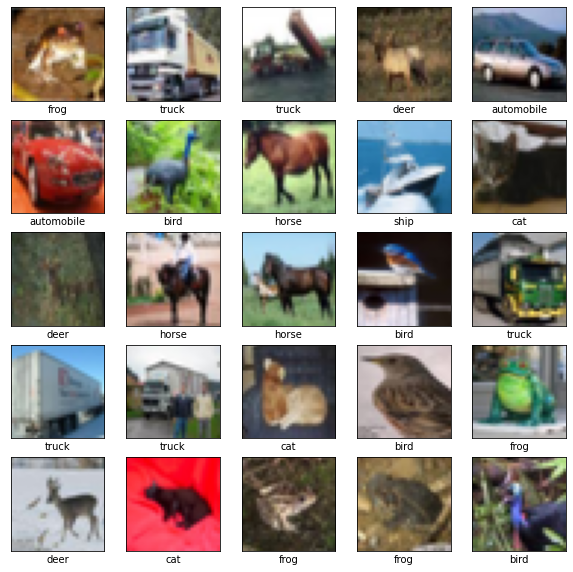

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Train model

In [9]:
# train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
# test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

In [10]:
x = layers.Input((32, 32, 3), name='input_layer')
y = layers.Conv2D(32, (3, 3), activation='relu')(x)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.MaxPooling2D((2, 2))(y)
y = layers.Conv2D(64, (3, 3), activation='relu')(y)
y = layers.Flatten()(y)
y = layers.Dense(64, activation='relu')(y)
y = layers.Dense(10)(y)
model = Model(x, y)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0     

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 153us/sample - loss: 1.5103 - accuracy: 0.4510 - val_loss: 1.2011 - val_accuracy: 0.5711
Epoch 2/10
50000/50000 [==============================] - 6s 119us/sample - loss: 1.1398 - accuracy: 0.5973 - val_loss: 1.1058 - val_accuracy: 0.6073
Epoch 3/10
50000/50000 [==============================] - 6s 125us/sample - loss: 0.9926 - accuracy: 0.6501 - val_loss: 0.9799 - val_accuracy: 0.6609
Epoch 4/10
50000/50000 [==============================] - 5s 101us/sample - loss: 0.8952 - accuracy: 0.6858 - val_loss: 0.9506 - val_accuracy: 0.6720
Epoch 5/10
50000/50000 [==============================] - 5s 103us/sample - loss: 0.8199 - accuracy: 0.7133 - val_loss: 0.9039 - val_accuracy: 0.6904
Epoch 6/10
50000/50000 [==============================] - 5s 103us/sample - loss: 0.7653 - accuracy: 0.7301 - val_loss: 0.9204 - val_accuracy: 0.6853
Epoch 7/10
50000/50000 [==========================

## Test activations

### Activation analysis

We applied workflow to visualize and evaluate similarity of activations for instances from same class.
* train KNN classifier from subset of test images
* predict class from activations for each class

In [12]:
# Create test and train set from original test 
a_labels, b_labels = get_train_test(test_labels.squeeze())
original_pred = model.predict(test_images).argmax(axis=1)
a_org_pred, b_org_pred = get_train_test(original_pred)

Layer:  1


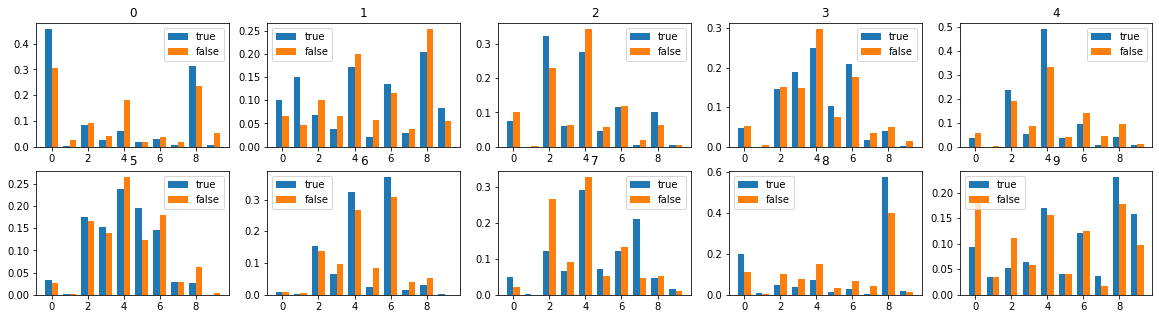

Layer:  2


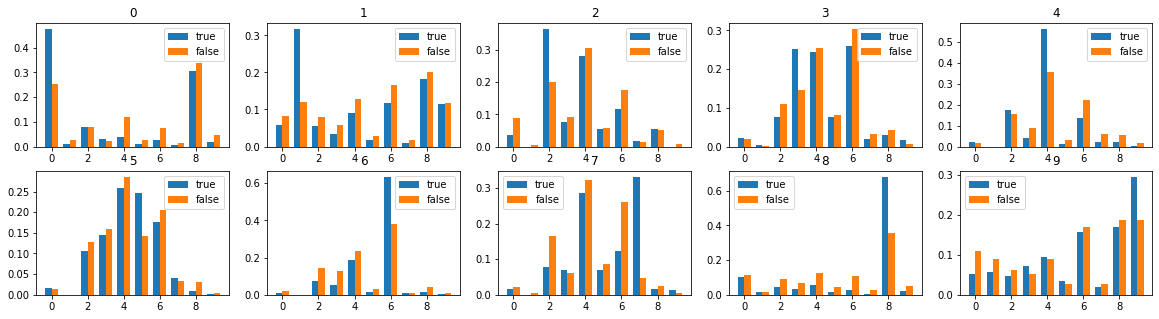

Layer:  3


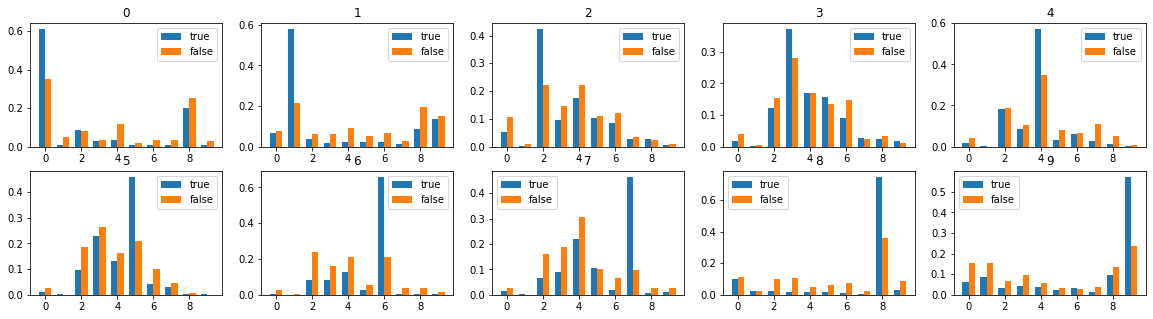

Layer:  4


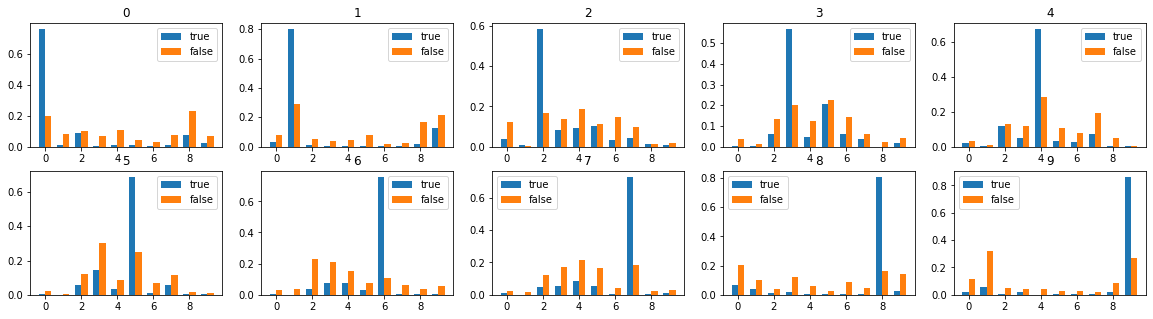

In [14]:
# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7])
layers_activations = layer_model.predict(test_images)

x = np.arange(10)  # the label locations
width = 0.35  # the width of the bars

for i, layer_activations in enumerate(layers_activations):
    print('Layer: ', i + 1)
    a_activations, b_activations = get_train_test(layer_activations)
    
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)
    knn_prediction = neigh.predict_proba(b_activations)
    
    visualization.plot_layers_activations(knn_prediction, b_org_pred, b_labels)


### Prediction of miss classification

In [15]:
a_data = []
b_data = []

# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7])
layers_activations = layer_model.predict_layers_activations(test_images)

for layer_activations in layers_activations:
    a_activations, b_activations = get_train_test(layer_activations)
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)

    a_pred = neigh.predict_proba(a_activations[a_labels==0])
    b_pred = neigh.predict_proba(b_activations[b_labels==0])
    
    a_data.append(a_pred)
    b_data.append(b_pred)

a_data = np.stack(a_data, axis=1)
b_data = np.stack(b_data, axis=1) 
a_0_labels = a_labels[a_labels==0] == a_org_pred[a_labels==0]
b_0_labels = b_labels[b_labels==0] == b_org_pred[b_labels==0]

In [16]:
a_data = a_data.reshape((a_data.shape[0], a_data.shape[1] * a_data.shape[2]))
b_data = b_data.reshape((b_data.shape[0], b_data.shape[1] * b_data.shape[2]))

In [17]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10)
clf.fit(a_data, a_0_labels)
pred = clf.predict(b_data)

In [19]:
print(classification_report(pred, b_0_labels))

              precision    recall  f1-score   support

       False       0.69      0.61      0.65        57
        True       0.85      0.88      0.86       137

    accuracy                           0.80       194
   macro avg       0.77      0.75      0.76       194
weighted avg       0.80      0.80      0.80       194



Analysis of cases predicted as airplane


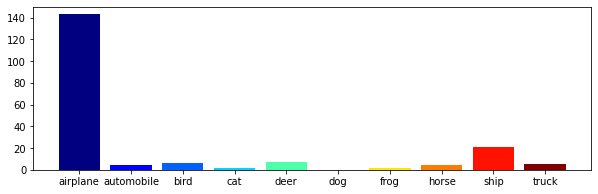

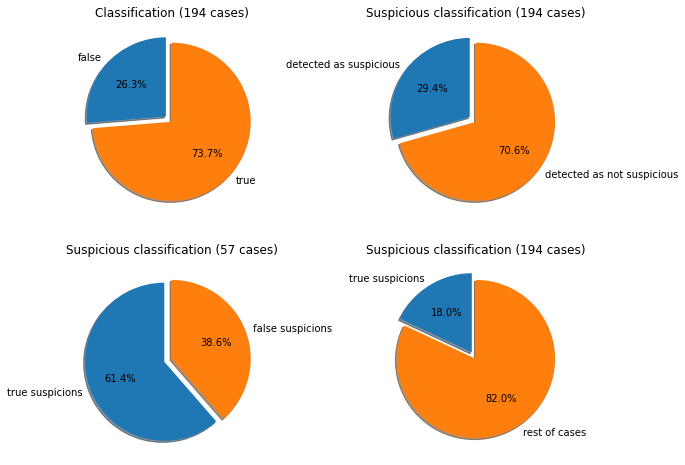

In [21]:
visualization.plot_suspicions_stats(pred, b_org_pred[b_labels==0], 0, class_names)

### Correct prediction of suspisions

Layer:  1


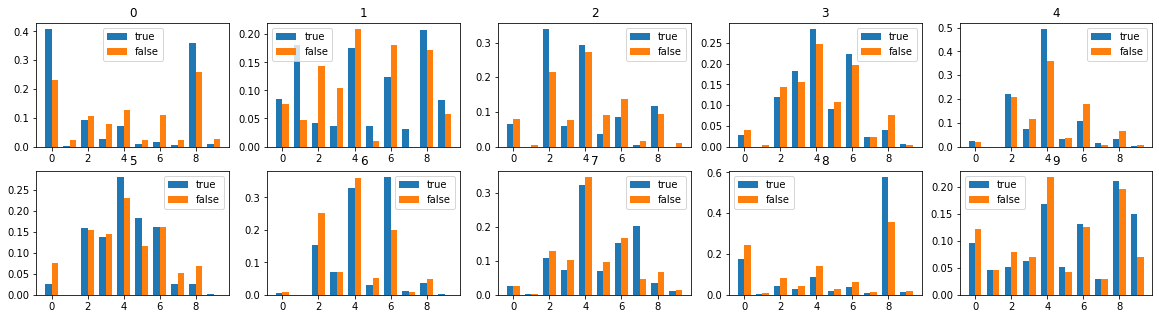

Layer:  2


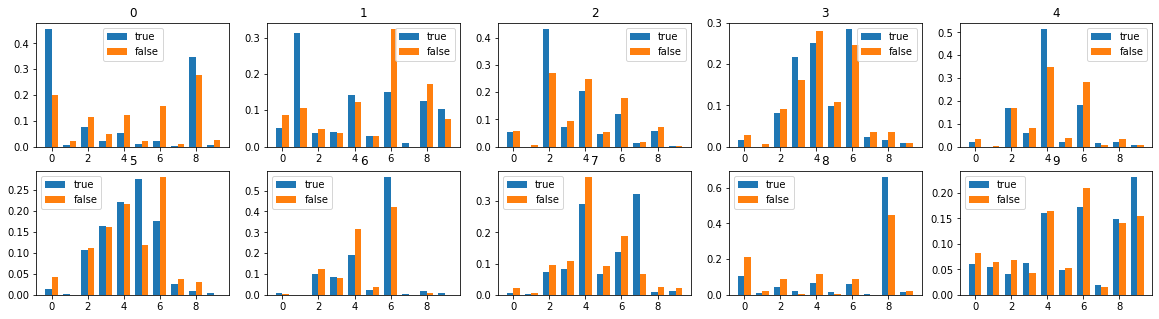

Layer:  3


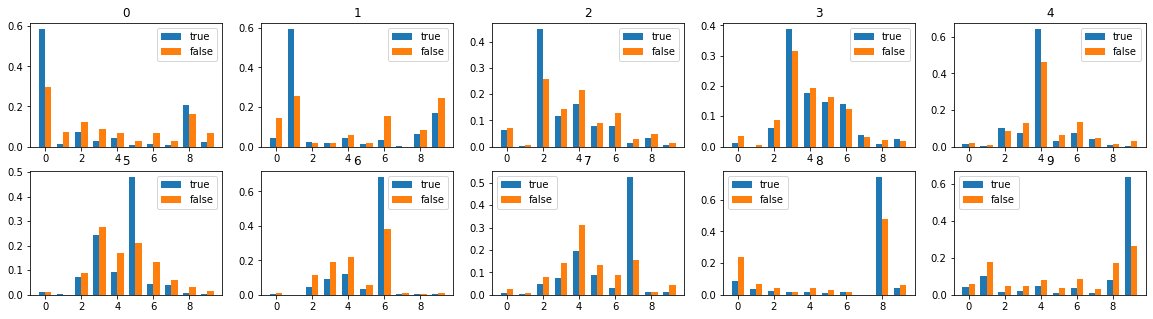

Layer:  4


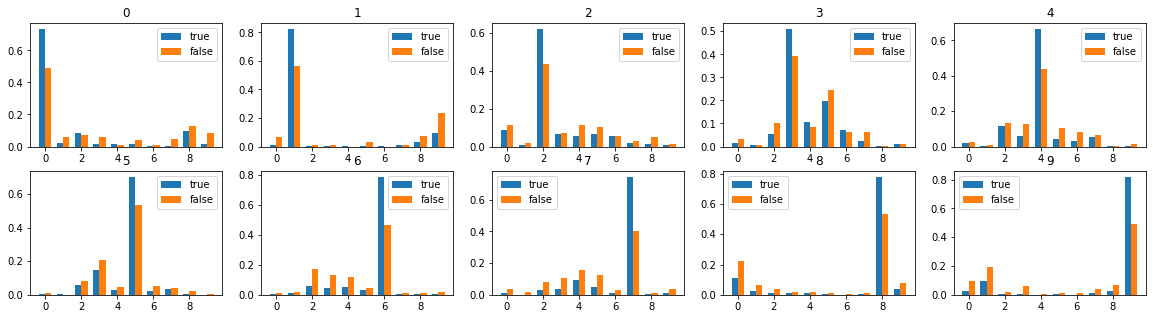

In [14]:
# Create test and train set from original test 
a_labels, b_labels = get_train_test(test_labels.squeeze())
original_pred = model.predict(test_images).argmax(axis=1)
a_org_pred, b_org_pred = get_train_test(original_pred)

# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7], class_names)
layers_activations = layer_model.predict_layers_activations(test_images)

for i, layer_activations in enumerate(layers_activations):
    print('Layer: ', i + 1)
    a_activations, b_activations = get_train_test(layer_activations)
    
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)
    knn_prediction = neigh.predict_proba(b_activations)
    
    visualization.plot_layers_activations_for_prediction(knn_prediction, b_org_pred, b_labels)

In [15]:
a_data = []
b_data = []

for layer_activations in layers_activations:
    a_activations, b_activations = get_train_test(layer_activations)
    neigh = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
    neigh.fit(a_activations, a_labels)

    a_pred = neigh.predict_proba(a_activations)
    b_pred = neigh.predict_proba(b_activations)
    
    a_data.append(a_pred)
    b_data.append(b_pred)

a_data = np.stack(a_data, axis=1)
b_data = np.stack(b_data, axis=1) 
a_data = a_data.reshape((a_data.shape[0], a_data.shape[1] * a_data.shape[2]))
b_data = b_data.reshape((b_data.shape[0], b_data.shape[1] * b_data.shape[2]))

              precision    recall  f1-score   support

       False       0.85      0.39      0.53       103
        True       0.36      0.83      0.50        42

    accuracy                           0.52       145
   macro avg       0.60      0.61      0.52       145
weighted avg       0.71      0.52      0.52       145

Analysis of cases predicted as dog


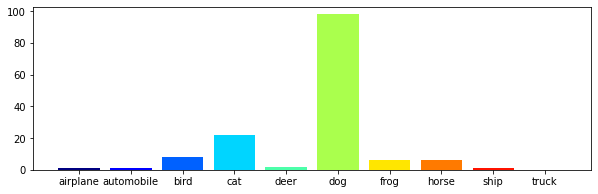

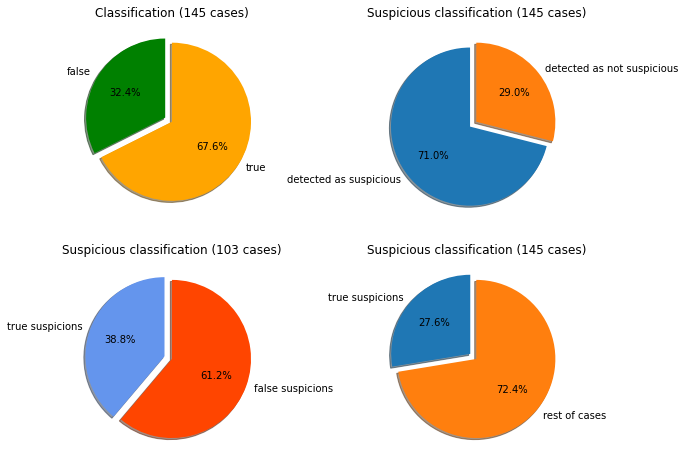

In [18]:
label = 5
clf = DecisionTreeClassifier(random_state=42, max_depth=5)

clf.fit(a_data[a_org_pred==label], a_labels[a_org_pred==label] == label)

pred = clf.predict(b_data[b_org_pred==label])
print(classification_report(pred, b_labels[b_org_pred==label] == label))
visualization.plot_suspicions_stats(pred, b_labels[b_org_pred==label], label, class_names)

### Visualization of path ( individual prediction )

In [13]:
# model with layers outputs
layer_model = LayerModel(model, [4,6,7], class_names)
# divide test images to train and test subset
a_images, b_images = get_train_test(test_images)
a_labels, b_labels = get_train_test(test_labels.squeeze())

# train KNN for each layer
a_pred_labels = model.predict(a_images).argmax(1)
layer_model.train(a_images, a_labels, a_pred_labels)


In [18]:
#####################################
# Neuron Selection
#####################################

In [14]:
layer_activations = layer_model.predict_layers_activations(b_images[:2])

In [43]:
b = layer_activations[2].mean(0).argsort()[-100:][::-1]

In [40]:
b.argsort()[-100:][::-1]

array([52,  1, 31,  0, 26, 13,  5, 61,  7, 28, 18, 49, 33, 25, 62, 15,  2,
       37, 38, 50, 60, 45, 21, 19, 48,  6, 10, 16,  9, 55, 35, 12, 20, 59,
       17, 14, 22,  8,  4,  3, 11, 29, 23, 24, 57, 56, 54, 53, 51, 47, 46,
       44, 43, 42, 41, 40, 39, 36, 34, 32, 30, 58, 27, 63])

In [85]:
common_f = layer_model.common_features(b_images[0], b_images[1], [2, 50, 2])

In [86]:
a = bi_lrp_models[0].analyze_pair(b_images[0], b_images[1], [2], common_f[0])

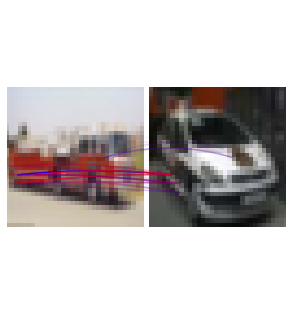

In [87]:
visualization.plot_relevances_full(a, b_images[0], b_images[1], [2])

In [70]:
a = bi_lrp_models[0].analyze_pair(b_images[0], b_images[1], [2])

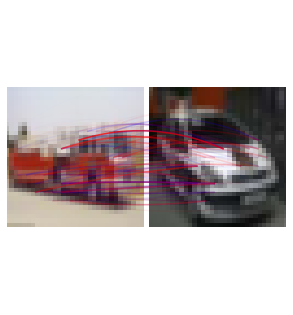

In [71]:
visualization.plot_relevances_full(a, b_images[0], b_images[1], [2])

In [17]:
#######################################

In [66]:
# define BiLrp models for each layer
bi_lrp_models = [BiLrp(
    innvestigate.create_analyzer("lrp.epsilon", 
                                 Model(model.input, model.layers[x].output),
                                 epsilon=1))
        for x in [4,6,7]]

In [15]:
# predict suspicios 
label = 0
b_pred_labels = model.predict(b_images).argmax(1)

susp_pred = layer_model.predict(b_images[b_pred_labels == label], label)

susp_imgs = b_images[b_pred_labels == label][susp_pred]

susp_labels = b_labels[b_pred_labels == label][susp_pred]

susp_idx = layer_model.get_neighbours_idxs_on_layers(b_images[b_pred_labels == label][susp_pred])

In [16]:
image_idx = 0
poolstride = [2]

image = susp_imgs[image_idx]
true_label = susp_labels[image_idx]
layers_neighbours_idxs = [x[image_idx] for x in susp_idx]

BiLrp_R = []

for layer, layer_neighbours in enumerate(layers_neighbours_idxs):
    print("Analyzing layer: ", layer)
    BiLrp_R.append(bi_lrp_models[layer].analyze_pair(image, a_images[layer_neighbours[0]], poolstride))

Analyzing layer:  0
Analyzing layer:  1
Analyzing layer:  2


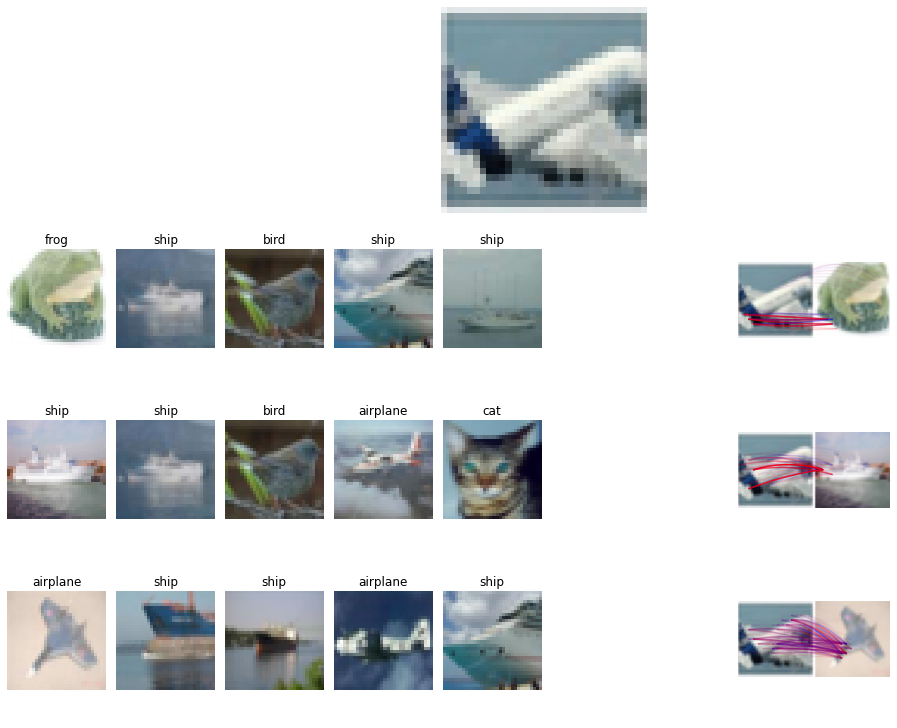

In [36]:
fig3 = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig3.add_gridspec(4, 2, height_ratios = [2.5, 2, 2, 2])

visualization.visualize_image(
    image,
    true_label,
    label,
    gs[0,:]
)
visualization.visualize_path(
    layers_neighbours_idxs,
    a_images,
    a_labels,
    class_names,
    gs[1:,0]
)

for layer, layer_neighbours in enumerate(layers_neighbours_idxs):
    visualization.plot_relevances_full(BiLrp_R[layer], image, a_images[layer_neighbours[0]], poolstride, gs=gs[1+ layer,1])

### Clustering


In [44]:
from sklearn.cluster import KMeans,DBSCAN 

In [13]:
# model with layers outputs
layer_model = LayerModel(model, [2,4,6,7], class_names)
# divide test images to train and test subset
a_images, b_images = get_train_test(test_images)
a_labels, b_labels = get_train_test(test_labels.squeeze())

# train KNN for each layer
a_pred_labels = model.predict(a_images).argmax(1)
# layer_model.train(a_images, a_labels, a_pred_labels)


In [20]:
layers_activations = layer_model.predict_layers_activations(a_images)
b_layers_activations = layer_model.predict_layers_activations(b_images)

In [38]:
kmeans = KMeans(n_clusters=10, random_state=1)

In [39]:
kmeans.fit(layers_activations[0])

KMeans(n_clusters=10, random_state=1)

In [42]:
metrics.homogeneity_score(a_labels, kmeans.labels_)

0.15951905790446214

In [43]:
metrics.cluster.contingency_matrix(a_labels, kmeans.labels_)

array([[211,   6,  48,  44,  54,  23,   7, 242, 119,  52],
       [ 47, 123, 216, 243,  23,  37,   6,  68,   4,  30],
       [ 50,   3,  16,  66,  58,  58, 147, 117,  31, 267],
       [ 13,   7,  22, 151, 122, 113,  19,  85,   3, 266],
       [ 33,   2,   8,  48,  54, 110, 185,  75,   4, 297],
       [ 18,   2,   9, 232,  92, 129,  44,  80,   2, 203],
       [  4,   2,  15,  87,  82, 207, 123,  19,   0, 250],
       [ 23,  15,  17, 151, 247,  76,  49,  69,   3, 150],
       [225,  13,  42,  74,   9,   5,   1, 326,  40,  41],
       [ 64, 131, 226,  93,  70,  24,   5, 137,   3,  38]])

In [49]:
db = DBSCAN(eps=3, min_samples=100)

In [50]:
db.fit(layers_activations[0])

DBSCAN(eps=3, min_samples=100)

In [51]:
metrics.cluster.contingency_matrix(a_labels, db.labels_)

array([[806],
       [797],
       [813],
       [801],
       [816],
       [811],
       [789],
       [800],
       [776],
       [791]])

In [48]:
db.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [1]:
!pip install --use-feature=2020-resolver "git+https://github.com/albermax/innvestigate.git@updates_towards_tf2.0"

  Cloning https://github.com/albermax/innvestigate.git (to revision updates_towards_tf2.0) to /tmp/pip-req-build-md6lipoq
     |████████████████████████████████| 829 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 421.8 MB 12.1 MB/s eta 0:00:01     |████████▊                       | 115.0 MB 12.2 MB/s eta 0:00:26     |███████████████████▋            | 259.0 MB 12.2 MB/s eta 0:00:14
     |████████████████████████████████| 50 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 448 kB 10.7 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 11.6 MB/s eta 0:00:01


  Created wheel for innvestigate: filename=innvestigate-2.0.0-py3-none-any.whl size=107093 sha256=2e671ed809f2394392314dbae58fa9c93b3910b11574e510dabffd2a07a26029
  Stored in directory: /tmp/pip-ephem-wheel-cache-5rm866ys/wheels/5c/25/10/76772cf76d6eb4346d31e1f6e32bce55ee94d9e7c6c98d1a3f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=493275 sha256=1d878d8a74b879c67f5994d02bfa1e5011a557e788373569e18aa67a4e03cd3e
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7635 sha256=f7f645095d35fc2685ba5412a0bcf30f8f1b02489db9dd62a5284d190c605f11
  Stored in directory: /root/.cache/pip/wheels/19/a7/b9/0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
Successfully built innvestigate future gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      